## Clone the github repository

In [1]:
!rm -r sample_data

In [2]:
!git clone https://github.com/manigalati/usad

Cloning into 'usad'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 99 (delta 31), reused 28 (delta 28), pack-reused 61
Unpacking objects: 100% (99/99), 2.81 MiB | 8.41 MiB/s, done.


In [3]:
%cd usad

/content/usad


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from utils import *
from usad import *

In [5]:
!nvidia-smi -L
device = get_default_device()

GPU 0: Tesla T4 (UUID: GPU-b30828f0-bcf0-f1ae-4404-f7cb05392cab)


## SWAT Dataset

the Dataset is a scaled down version of a real-world industrial water treatment plant producing filtered water.The collected dataset consists of 11 days of continuous operation: 7 days collected under normal operations and 4 days collected with attack scenarios

In [6]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

input/SWaT_Dataset_Normal_v1.csv
[==================================================] 163.77MB/163.77MB
input/SWaT_Dataset_Attack_v0.csv
[==================================================] 127.27MB/127.27MB


## Data Preprocessing

In [7]:
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

<ipython-input-7-64bc0604a4a1>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)


(495000, 51)

In [8]:
for i in list(normal):
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [10]:
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

<ipython-input-10-f9b93f734ade>:1: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)


(449919, 51)

In [11]:
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

In [12]:
from sklearn import preprocessing
x = attack.values
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [13]:
window_size=12
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [14]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Train the Adversarial Autoencoder

In [15]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0255, val_loss2: 0.0258
Epoch [1], val_loss1: 0.0263, val_loss2: -0.0065
Epoch [2], val_loss1: 0.1069, val_loss2: -0.0841
Epoch [3], val_loss1: 0.0394, val_loss2: -0.0299
Epoch [4], val_loss1: 0.0421, val_loss2: -0.0347
Epoch [5], val_loss1: 0.0432, val_loss2: -0.0374
Epoch [6], val_loss1: 0.0439, val_loss2: -0.0391
Epoch [7], val_loss1: 0.0451, val_loss2: -0.0410
Epoch [8], val_loss1: 0.0445, val_loss2: -0.0410
Epoch [9], val_loss1: 0.0455, val_loss2: -0.0423
Epoch [10], val_loss1: 0.0466, val_loss2: -0.0439
Epoch [11], val_loss1: 0.0551, val_loss2: -0.0495
Epoch [12], val_loss1: 0.0616, val_loss2: -0.0584
Epoch [13], val_loss1: 0.0423, val_loss2: -0.0384
Epoch [14], val_loss1: 0.0403, val_loss2: -0.0368
Epoch [15], val_loss1: 0.0665, val_loss2: -0.0636
Epoch [16], val_loss1: 0.0673, val_loss2: -0.0646
Epoch [17], val_loss1: 0.0751, val_loss2: -0.0685
Epoch [18], val_loss1: 0.0744, val_loss2: -0.0689
Epoch [19], val_loss1: 0.0756, val_loss2: -0.0704
Epoch [20],

In [16]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

In [17]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

## Model Evaluation and Inference

In [18]:
results=testing(model,test_loader)

In [23]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [24]:
y_pred

array([0.02558808, 0.02562073, 0.02564567, ..., 0.5310569 , 0.53100437,
       0.53091055], dtype=float32)

In [26]:
y_test[:5]

[0, 0, 0, 0, 0]

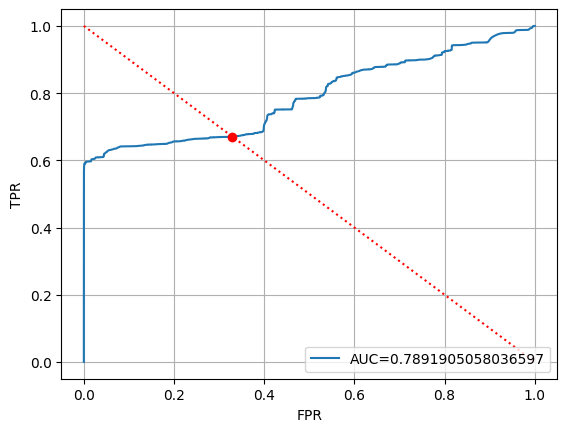

In [19]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
threshold=ROC(y_test,y_pred)#find the best threshold that give the best F1 score using the roc curve

In [29]:
print(threshold)

[0.42743772]
